# Imputation Research Project <img src="https://miro.medium.com/max/1400/1*JPZcoAD9kERfEQxwlaPT-A.jpeg" alt="Alt text image not displaying" width="500" align="right" />
## Notebook 1.1: Exploratory Data Analysis

**Author:** Chike Odenigbo

**Date:** November 25th, 2022

**Notebook Structure:**

* 1.0 Preprocessing

* **1.1 Exploratory Data Analysis**

* 1.2 Masking

* 2.* Models


Water Sugar lutein_zeaxanthin Alcohol

In [46]:
# DOCUMENTATION: https://rianneschouten.github.io/pyampute/build/html/pyampute.ampute.html
# https://bookdown.org/rwnahhas/RMPH/mi-mechanisms.html
# https://stats.stackexchange.com/questions/462507/how-to-decide-whether-missing-values-are-mar-mcar-or-mnar
from pyampute.ampute import MultivariateAmputation
from pyampute.exploration.mcar_statistical_tests import MCARTest
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import warnings
import itertools
import pandas as pd
import os
from src.visualization.visualize import histogram, box_plot, bar_plot
from pathlib import Path
from notebook_config import ROOT_DIR # setup.py file changed the root of the project so it is set in the config file
ROOT_DIR = ROOT_DIR.as_posix() # convert root path to windows readable path (i.e. change backslash to forward slash)
import numpy as np
import random
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
# warnings.filterwarnings('ignore', category=FutureWarning)
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [4]:
notebook_nm = '2.1-masking'
fig_dir = f'{ROOT_DIR}/reports/figures/'
output_prefix = notebook_nm

In [5]:
# nutrition_df.drop(['name','serving_size'],axis='columns')
def ampute(df, target_col, mechanism, prop = 0.2, seed = 1): 
    ma = MultivariateAmputation(prop = prop, patterns = [{'incomplete_vars':[target_col] ,'mechanism':mechanism}],verbose = False, seed = seed)
    output_df = ma.fit_transform(df)
    return output_df

In [6]:
pd.set_option('display.max_columns', None)
nutrition_df = pd.read_csv(f'{ROOT_DIR}/data/interim/nutrition_numerical.csv').dropna(axis = 'rows')#.reset_index(drop = True)
nutrient_stats_df = pd.read_csv(f'{ROOT_DIR}/data/interim/nutrition_facts_statistics.csv')
nutrient_stats_df
# ma = MultivariateAmputation(prop = 0.2, patterns = [{'incomplete_vars':['water'] ,'mechanism':'MCAR'}],verbose = True)
# na_water_df = ma.fit_transform(nutrition_df.drop(['name','serving_size'],axis='columns'))
# na_water_df

nutrient  zero_value_counts  observation_count  \
0         alcohol               8715               8789   
1       galactose               8602               8789   
2     theobromine               8545               8789   
3        caffeine               8488               8789   
4         lactose               8390               8789   
..            ...                ...                ...   
68        protein                358               8789   
69         sodium                355               8789   
70          water                 96               8789   
71   serving_size                  0               8789   
72  saturated_fat                  0               8789   

    z_score_zero_value_counts  percent_zero  outlier_count  \
0                    1.964985      0.991580             74   
1                    1.922415      0.978723            187   
2                    1.900942      0.972238            244   
3                    1.879468      0.965753            301   
4                    1.842549      0.954602            399   
..                        ...           ...            ...   
68                  -1.183318      0.040733             49   
69                  -1.184448      0.040391            473   
70                  -1.282020      0.010923              0   
71                  -1.318186      0.000000              0   
72                  -1.318186      0.000000            535   

    variation_coefficient  missing_rate  median_value  tertile_zero_value  
0               13.615567      0.000000          0.00                   1  
1               16.214746      0.000000          0.00                   1  
2               12.982805      0.000000          0.00                   1  
3               31.458645      0.000000          0.00                   1  
4               13.917778      0.000000          0.00                   1  
..                    ...           ...           ...                 ...  
68               0.928165      0.000000          8.02                   3  
69               3.065803      0.000000         84.00                   3  
70               0.568690      0.000000         63.08                   3  
71               0.000000      0.000000        100.00                   3  
72               1.640199     18.090795          2.20                   3  

[73 rows x 10 columns]

In [7]:
random.seed(30)
param_grid = {
    'prop':[0.1,0.2,0.3],
#     'score_to_probability_func':['sigmoid-right', 'sigmoid-left'],
    'columns':nutrition_df.drop(['name','serving_size'],axis='columns').columns.values
}
keys, values = zip(*param_grid.items())
permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]
# params = random.sample(permutations_dicts, 60)
# params

In [8]:
len(permutations_dicts)

216

In [9]:
result_cols = ['column','prop_na','mcar_test_mcar','mnar_test_mnar','mar_test_mar']
df = pd.DataFrame(columns=result_cols)
impute_test_df = [df]
for param in permutations_dicts:
    try:
    #     mechanism = param['mechanism']
        prop = param['prop']
        col = param['columns']
        print(param)
        mcar_df = ampute(nutrition_df.drop(['name','serving_size'],axis='columns'), col, mechanism = 'MCAR', prop = prop, seed = 20)
        mnar_df = ampute(nutrition_df.drop(['name','serving_size'],axis='columns'), col, mechanism = 'MNAR', prop = prop, seed = 20)
        mar_df = ampute(nutrition_df.drop(['name','serving_size'],axis='columns'), col, mechanism = 'MAR', prop = prop, seed = 20)
        mcar_p_val = mt.little_mcar_test(mcar_df)
        mnar_p_val = mt.little_mcar_test(mnar_df)
        mar_p_val = mt.little_mcar_test(mar_df)
    #     print(f'MCAR Test {col} mcar: {mcar_p_val}')
    #     print(f'MCAR Test {col} mnar: {mnar_p_val}')
    #     print(f'MCAR Test {col} mar: {mar_p_val}')
        data = pd.DataFrame([[col,prop, mcar_p_val, mnar_p_val ,mar_p_val]], columns=result_cols)
        # store DataFrame in list
        impute_test_df.append(data)
    except:
        continue
# see pd.concat documentation for more info
impute_test_df = pd.concat(impute_test_df)
impute_test_df

2022-11-27 15:32:08,492 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'total_fat'}


2022-11-27 15:32:08,781 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:09,043 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:09,540 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'saturated_fat'}


2022-11-27 15:32:09,750 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:09,970 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:10,530 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:10,712 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is

{'prop': 0.1, 'columns': 'cholesterol'}


2022-11-27 15:32:10,889 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:11,280 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:11,472 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'sodium'}


2022-11-27 15:32:11,686 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:12,294 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'choline'}


2022-11-27 15:32:12,579 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:12,878 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:13,311 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:13,479 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is

{'prop': 0.1, 'columns': 'folate'}


2022-11-27 15:32:13,679 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:14,121 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:14,305 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'folic_acid'}


2022-11-27 15:32:14,511 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:14,906 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:15,100 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'niacin'}


2022-11-27 15:32:15,295 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:15,700 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:15,871 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'pantothenic_acid'}


2022-11-27 15:32:16,111 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:16,498 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:16,669 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'riboflavin'}


2022-11-27 15:32:16,853 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:17,282 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:17,475 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'thiamin'}


2022-11-27 15:32:17,692 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:18,080 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:18,271 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'vitamin_a'}


2022-11-27 15:32:18,470 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:18,859 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:19,042 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'vitamin_a_rae'}


2022-11-27 15:32:19,229 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:19,594 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:19,785 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'carotene_alpha'}


2022-11-27 15:32:19,978 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:20,369 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:20,549 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'carotene_beta'}


2022-11-27 15:32:20,742 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:21,150 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'cryptoxanthin_beta'}


2022-11-27 15:32:21,351 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:21,577 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:22,050 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:22,240 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is

{'prop': 0.1, 'columns': 'lutein_zeaxanthin'}


2022-11-27 15:32:22,431 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:22,838 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:23,035 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'vitamin_b12'}


2022-11-27 15:32:23,220 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:23,639 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'vitamin_b6'}


2022-11-27 15:32:23,880 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:24,111 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:24,721 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'vitamin_c'}


2022-11-27 15:32:24,941 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:25,134 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:25,573 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:25,750 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is

{'prop': 0.1, 'columns': 'vitamin_d'}


2022-11-27 15:32:25,941 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:26,386 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'vitamin_e'}


2022-11-27 15:32:26,592 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:26,823 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:27,259 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'tocopherol_alpha'}


2022-11-27 15:32:27,469 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:27,710 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:28,370 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'vitamin_k'}


2022-11-27 15:32:28,569 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:28,770 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:29,227 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:29,432 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is

{'prop': 0.1, 'columns': 'calcium'}


2022-11-27 15:32:29,649 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:30,032 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'copper'}


2022-11-27 15:32:30,256 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:30,472 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:31,023 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'irom'}


2022-11-27 15:32:31,250 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:31,458 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:31,852 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:32,032 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is

{'prop': 0.1, 'columns': 'magnesium'}


2022-11-27 15:32:32,251 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:32,711 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'manganese'}


2022-11-27 15:32:32,910 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:33,138 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:33,637 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'phosphorous'}


2022-11-27 15:32:33,853 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:34,097 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:34,657 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'potassium'}


2022-11-27 15:32:34,893 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:35,127 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:35,709 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'selenium'}


2022-11-27 15:32:35,904 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:36,119 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:36,602 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'zink'}


2022-11-27 15:32:36,814 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:37,084 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:37,481 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:37,666 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is

{'prop': 0.1, 'columns': 'protein'}


2022-11-27 15:32:37,887 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:38,311 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'alanine'}


2022-11-27 15:32:38,505 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:38,717 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:39,180 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:39,349 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is

{'prop': 0.1, 'columns': 'arginine'}


2022-11-27 15:32:39,561 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:39,949 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:40,115 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'aspartic_acid'}


2022-11-27 15:32:40,310 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:40,717 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:40,915 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'cystine'}


2022-11-27 15:32:41,113 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:41,495 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:41,683 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'glutamic_acid'}


2022-11-27 15:32:41,883 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:42,303 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:42,477 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'glycine'}


2022-11-27 15:32:42,673 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:43,063 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:43,241 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'histidine'}


2022-11-27 15:32:43,460 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:43,874 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:44,051 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'hydroxyproline'}


2022-11-27 15:32:44,249 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:44,636 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:44,818 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'isoleucine'}


2022-11-27 15:32:45,019 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:45,431 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:45,609 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'leucine'}


2022-11-27 15:32:45,794 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:46,159 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:46,359 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'lysine'}


2022-11-27 15:32:46,566 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:46,966 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:47,131 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'methionine'}


2022-11-27 15:32:47,314 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:47,769 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'phenylalanine'}


2022-11-27 15:32:47,983 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:48,189 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:48,580 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:48,759 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is

{'prop': 0.1, 'columns': 'proline'}


2022-11-27 15:32:48,969 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:49,361 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:49,540 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'serine'}


2022-11-27 15:32:49,741 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:50,139 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:50,322 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'threonine'}


2022-11-27 15:32:50,531 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:50,928 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:51,130 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'tryptophan'}


2022-11-27 15:32:51,342 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:51,735 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:51,920 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'tyrosine'}


2022-11-27 15:32:52,124 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:52,569 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:52,749 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'valine'}


2022-11-27 15:32:52,958 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:53,372 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:53,557 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'carbohydrate'}


2022-11-27 15:32:53,760 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:54,181 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:54,374 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'fiber'}


2022-11-27 15:32:54,589 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:54,996 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'sugars'}


2022-11-27 15:32:55,193 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:55,405 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:55,822 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'fructose'}


2022-11-27 15:32:56,036 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:56,247 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:56,777 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'galactose'}


2022-11-27 15:32:56,980 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:57,182 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:57,570 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:57,758 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is

{'prop': 0.1, 'columns': 'glucose'}


2022-11-27 15:32:57,969 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:58,358 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'lactose'}


2022-11-27 15:32:58,555 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:58,756 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:59,171 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:59,358 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is

{'prop': 0.1, 'columns': 'maltose'}


2022-11-27 15:32:59,553 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:32:59,941 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:00,129 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'sucrose'}


2022-11-27 15:33:00,331 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:00,729 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:00,909 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'fat'}


2022-11-27 15:33:01,121 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:01,553 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:01,723 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'saturated_fatty_acids'}


2022-11-27 15:33:01,924 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:02,331 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:02,529 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'monounsaturated_fatty_acids'}


2022-11-27 15:33:02,744 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:03,129 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:03,314 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'polyunsaturated_fatty_acids'}


2022-11-27 15:33:03,519 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:03,923 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:04,106 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'fatty_acids_total_trans'}


2022-11-27 15:33:04,311 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:04,692 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:04,880 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'alcohol'}


2022-11-27 15:33:05,090 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:05,491 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:05,676 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'ash'}


2022-11-27 15:33:05,880 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:06,270 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:06,465 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'caffeine'}


2022-11-27 15:33:06,674 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:07,063 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:07,241 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'theobromine'}


2022-11-27 15:33:07,453 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:07,850 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:08,032 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'water'}


2022-11-27 15:33:08,221 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:08,614 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:08,811 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'total_fat'}


2022-11-27 15:33:09,019 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:09,416 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:09,605 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'saturated_fat'}


2022-11-27 15:33:09,830 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:10,249 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:10,453 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'cholesterol'}


2022-11-27 15:33:10,664 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:11,159 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:11,349 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'sodium'}


2022-11-27 15:33:11,550 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:11,949 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:12,134 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'choline'}


2022-11-27 15:33:12,331 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:12,729 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:12,909 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'folate'}


2022-11-27 15:33:13,130 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:13,600 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:13,791 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'folic_acid'}


2022-11-27 15:33:14,008 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:14,448 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:14,628 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'niacin'}


2022-11-27 15:33:14,842 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:15,270 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:15,466 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'pantothenic_acid'}


2022-11-27 15:33:15,679 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:16,098 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'riboflavin'}


2022-11-27 15:33:16,338 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:16,558 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:16,991 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:17,166 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is

{'prop': 0.2, 'columns': 'thiamin'}


2022-11-27 15:33:17,371 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:17,770 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:17,966 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'vitamin_a'}


2022-11-27 15:33:18,170 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:18,559 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:18,743 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'vitamin_a_rae'}


2022-11-27 15:33:18,952 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:19,440 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'carotene_alpha'}


2022-11-27 15:33:19,665 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:19,920 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:20,431 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:20,625 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is

{'prop': 0.2, 'columns': 'carotene_beta'}


2022-11-27 15:33:20,852 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:21,291 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'cryptoxanthin_beta'}


2022-11-27 15:33:21,505 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:21,688 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:22,074 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'lutein_zeaxanthin'}


2022-11-27 15:33:22,298 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:22,509 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:22,944 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'vitamin_b12'}


2022-11-27 15:33:23,176 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:23,393 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:23,890 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'vitamin_b6'}


2022-11-27 15:33:24,100 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:24,319 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:24,871 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'vitamin_c'}


2022-11-27 15:33:25,106 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:25,353 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:25,953 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'vitamin_d'}


2022-11-27 15:33:26,201 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:26,415 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:26,898 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:27,078 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is

{'prop': 0.2, 'columns': 'vitamin_e'}


2022-11-27 15:33:27,291 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:27,739 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:27,922 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'tocopherol_alpha'}


2022-11-27 15:33:28,119 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:28,531 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:28,723 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'vitamin_k'}


2022-11-27 15:33:28,931 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:29,449 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'calcium'}


2022-11-27 15:33:29,663 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:29,862 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:30,280 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'copper'}


2022-11-27 15:33:30,481 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:30,691 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:31,113 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:31,309 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is

{'prop': 0.2, 'columns': 'irom'}


2022-11-27 15:33:31,519 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:31,898 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:32,093 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'magnesium'}


2022-11-27 15:33:32,289 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:32,701 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:32,900 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'manganese'}


2022-11-27 15:33:33,109 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:33,490 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:33,685 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'phosphorous'}


2022-11-27 15:33:33,892 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:34,302 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'potassium'}


2022-11-27 15:33:34,515 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:34,731 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:35,161 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:35,364 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is

{'prop': 0.2, 'columns': 'selenium'}


2022-11-27 15:33:35,557 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:35,951 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:36,125 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'zink'}


2022-11-27 15:33:36,350 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:36,767 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:36,969 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'protein'}


2022-11-27 15:33:37,200 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:37,665 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'alanine'}


2022-11-27 15:33:37,863 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:38,071 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:38,525 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'arginine'}


2022-11-27 15:33:38,728 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:38,954 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:39,554 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:39,752 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is

{'prop': 0.2, 'columns': 'aspartic_acid'}


2022-11-27 15:33:39,962 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:40,370 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:40,565 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'cystine'}


2022-11-27 15:33:40,770 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:41,175 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:41,383 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'glutamic_acid'}


2022-11-27 15:33:41,584 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:42,006 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:42,181 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'glycine'}


2022-11-27 15:33:42,393 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:42,792 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:42,989 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'histidine'}


2022-11-27 15:33:43,198 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:43,634 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'hydroxyproline'}


2022-11-27 15:33:43,831 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:44,029 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:44,410 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:44,588 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is

{'prop': 0.2, 'columns': 'isoleucine'}


2022-11-27 15:33:44,779 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:45,208 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:45,392 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'leucine'}


2022-11-27 15:33:45,594 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:46,024 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:46,209 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'lysine'}


2022-11-27 15:33:46,433 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:46,871 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:47,058 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'methionine'}


2022-11-27 15:33:47,258 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:47,689 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:47,884 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'phenylalanine'}


2022-11-27 15:33:48,081 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:48,499 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:48,681 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'proline'}


2022-11-27 15:33:48,881 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:49,332 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'serine'}


2022-11-27 15:33:49,531 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:49,733 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:50,183 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'threonine'}


2022-11-27 15:33:50,387 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:50,600 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:50,989 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:51,193 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is

{'prop': 0.2, 'columns': 'tryptophan'}


2022-11-27 15:33:51,398 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:51,892 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:52,070 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'tyrosine'}


2022-11-27 15:33:52,270 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:52,747 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:52,938 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'valine'}


2022-11-27 15:33:53,137 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:53,567 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:53,740 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'carbohydrate'}


2022-11-27 15:33:53,954 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:54,362 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:54,546 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'fiber'}


2022-11-27 15:33:54,759 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:55,222 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:55,406 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'sugars'}


2022-11-27 15:33:55,613 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:56,069 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'fructose'}


2022-11-27 15:33:56,291 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:56,491 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:56,922 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:57,100 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is

{'prop': 0.2, 'columns': 'galactose'}


2022-11-27 15:33:57,301 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:57,689 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:57,869 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'glucose'}


2022-11-27 15:33:58,091 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:58,592 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:58,771 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'lactose'}


2022-11-27 15:33:58,953 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:59,363 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:33:59,545 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'maltose'}


2022-11-27 15:33:59,756 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:00,131 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:00,303 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'sucrose'}


2022-11-27 15:34:00,508 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:00,889 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:01,079 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'fat'}


2022-11-27 15:34:01,291 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:01,679 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:01,869 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'saturated_fatty_acids'}


2022-11-27 15:34:02,078 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:02,518 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'monounsaturated_fatty_acids'}


2022-11-27 15:34:02,751 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:02,971 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:03,405 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:03,600 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is

{'prop': 0.2, 'columns': 'polyunsaturated_fatty_acids'}


2022-11-27 15:34:03,807 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:04,190 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:04,383 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'fatty_acids_total_trans'}


2022-11-27 15:34:04,595 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:05,023 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'alcohol'}


2022-11-27 15:34:05,298 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:05,528 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:06,012 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:06,198 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is

{'prop': 0.2, 'columns': 'ash'}


2022-11-27 15:34:06,400 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:06,837 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'caffeine'}


2022-11-27 15:34:07,043 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:07,260 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:07,658 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:07,821 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is

{'prop': 0.2, 'columns': 'theobromine'}


2022-11-27 15:34:08,026 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:08,441 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:08,626 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'water'}


2022-11-27 15:34:08,831 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:09,229 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:09,421 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'total_fat'}


2022-11-27 15:34:09,679 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:10,131 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:10,309 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'saturated_fat'}


2022-11-27 15:34:10,501 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:10,931 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:11,109 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'cholesterol'}


2022-11-27 15:34:11,301 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:11,675 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:11,861 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'sodium'}


2022-11-27 15:34:12,064 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:12,452 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:12,650 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'choline'}


2022-11-27 15:34:12,864 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:13,306 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'folate'}


2022-11-27 15:34:13,550 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:13,749 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:14,142 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'folic_acid'}


2022-11-27 15:34:14,364 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:14,569 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:15,002 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:15,186 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is

{'prop': 0.3, 'columns': 'niacin'}


2022-11-27 15:34:15,391 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:15,788 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:15,970 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'pantothenic_acid'}


2022-11-27 15:34:16,171 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:16,566 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:16,742 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'riboflavin'}


2022-11-27 15:34:16,951 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:17,361 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:17,538 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'thiamin'}


2022-11-27 15:34:17,744 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:18,182 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'vitamin_a'}


2022-11-27 15:34:18,424 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:18,656 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:19,084 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:19,261 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is

{'prop': 0.3, 'columns': 'vitamin_a_rae'}


2022-11-27 15:34:19,463 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:19,853 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:20,041 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'carotene_alpha'}


2022-11-27 15:34:20,243 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:20,663 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'carotene_beta'}


2022-11-27 15:34:20,861 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:21,073 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:21,649 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:21,841 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is

{'prop': 0.3, 'columns': 'cryptoxanthin_beta'}


2022-11-27 15:34:22,050 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:22,429 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:22,612 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'lutein_zeaxanthin'}


2022-11-27 15:34:22,839 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:23,225 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'vitamin_b12'}


2022-11-27 15:34:23,417 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:23,621 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:24,029 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:24,210 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is

{'prop': 0.3, 'columns': 'vitamin_b6'}


2022-11-27 15:34:24,420 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:24,819 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:25,009 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'vitamin_c'}


2022-11-27 15:34:25,205 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:25,648 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:25,832 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'vitamin_d'}


2022-11-27 15:34:26,047 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:26,458 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:26,646 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'vitamin_e'}


2022-11-27 15:34:26,854 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:27,269 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:27,473 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'tocopherol_alpha'}


2022-11-27 15:34:27,706 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:28,130 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'vitamin_k'}


2022-11-27 15:34:28,337 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:28,554 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:28,940 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:29,142 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is

{'prop': 0.3, 'columns': 'calcium'}


2022-11-27 15:34:29,330 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:29,771 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:29,968 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'copper'}


2022-11-27 15:34:30,194 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:30,600 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:30,779 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'irom'}


2022-11-27 15:34:30,993 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:31,399 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:31,593 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'magnesium'}


2022-11-27 15:34:31,801 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:32,178 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:32,371 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'manganese'}


2022-11-27 15:34:32,576 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:32,972 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:33,149 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'phosphorous'}


2022-11-27 15:34:33,341 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:33,758 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'potassium'}


2022-11-27 15:34:33,951 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:34,144 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:34,552 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'selenium'}


2022-11-27 15:34:34,754 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:35,010 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:35,456 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:35,666 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is

{'prop': 0.3, 'columns': 'zink'}


2022-11-27 15:34:35,882 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:36,282 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:36,470 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'protein'}


2022-11-27 15:34:36,664 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:37,079 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:37,279 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'alanine'}


2022-11-27 15:34:37,495 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:37,888 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:38,070 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'arginine'}


2022-11-27 15:34:38,282 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:38,702 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:38,870 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'aspartic_acid'}


2022-11-27 15:34:39,079 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:39,481 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:39,684 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'cystine'}


2022-11-27 15:34:39,894 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:40,331 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:40,509 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'glutamic_acid'}


2022-11-27 15:34:40,709 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:41,120 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:41,304 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'glycine'}


2022-11-27 15:34:41,534 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:41,991 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'histidine'}


2022-11-27 15:34:42,192 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:42,401 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:42,815 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:43,012 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is

{'prop': 0.3, 'columns': 'hydroxyproline'}


2022-11-27 15:34:43,225 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:43,636 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:43,822 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'isoleucine'}


2022-11-27 15:34:44,033 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:44,415 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:44,593 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'leucine'}


2022-11-27 15:34:44,809 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:45,211 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:45,410 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'lysine'}


2022-11-27 15:34:45,609 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:46,071 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'methionine'}


2022-11-27 15:34:46,287 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:46,499 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:46,888 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:47,071 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is

{'prop': 0.3, 'columns': 'phenylalanine'}


2022-11-27 15:34:47,314 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:47,825 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:48,010 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'proline'}


2022-11-27 15:34:48,214 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:48,641 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:48,829 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'serine'}


2022-11-27 15:34:49,024 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:49,424 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:49,618 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'threonine'}


2022-11-27 15:34:49,811 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:50,202 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:50,389 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'tryptophan'}


2022-11-27 15:34:50,606 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:51,019 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'tyrosine'}


2022-11-27 15:34:51,219 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:51,431 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:51,805 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:51,989 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is

{'prop': 0.3, 'columns': 'valine'}


2022-11-27 15:34:52,204 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:52,591 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:52,761 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'carbohydrate'}


2022-11-27 15:34:52,942 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:53,352 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'fiber'}


2022-11-27 15:34:53,542 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:53,749 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:54,172 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:54,361 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is

{'prop': 0.3, 'columns': 'sugars'}


2022-11-27 15:34:54,561 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:55,010 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:55,189 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'fructose'}


2022-11-27 15:34:55,398 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:55,809 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:55,982 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'galactose'}


2022-11-27 15:34:56,174 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:56,618 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:56,811 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'glucose'}


2022-11-27 15:34:57,029 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:57,424 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:57,590 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'lactose'}


2022-11-27 15:34:57,809 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:58,213 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:58,400 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'maltose'}


2022-11-27 15:34:58,612 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:58,998 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:59,180 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'sucrose'}


2022-11-27 15:34:59,373 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:34:59,821 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'fat'}


2022-11-27 15:35:00,023 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:35:00,218 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:35:00,614 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:35:00,804 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is

{'prop': 0.3, 'columns': 'saturated_fatty_acids'}


2022-11-27 15:35:01,011 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:35:01,412 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:35:01,591 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'monounsaturated_fatty_acids'}


2022-11-27 15:35:01,800 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:35:02,256 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:35:02,454 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'polyunsaturated_fatty_acids'}


2022-11-27 15:35:02,664 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:35:03,052 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:35:03,237 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'fatty_acids_total_trans'}


2022-11-27 15:35:03,451 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:35:03,833 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:35:04,023 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'alcohol'}


2022-11-27 15:35:04,230 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:35:04,629 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:35:04,791 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'ash'}


2022-11-27 15:35:05,010 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:35:05,405 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:35:05,608 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'caffeine'}


2022-11-27 15:35:05,821 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:35:06,260 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'theobromine'}


2022-11-27 15:35:06,473 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:35:06,688 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:35:07,144 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'water'}


2022-11-27 15:35:07,399 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:35:07,645 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


Empty DataFrame
Columns: [column, prop_na, mcar_test_mcar, mnar_test_mnar, mar_test_mar]
Index: []

In [10]:
# impute_test_df = pd.concat(impute_test_df)
impute_test_df

Empty DataFrame
Columns: [column, prop_na, mcar_test_mcar, mnar_test_mnar, mar_test_mar]
Index: []

In [11]:
nutrient_impute_test_df = pd.merge(nutrient_stats_df, impute_test_df, left_on='nutrient', right_on='column').drop('column',axis = 'columns')
nutrient_impute_test_df

Empty DataFrame
Columns: [nutrient, zero_value_counts, observation_count, z_score_zero_value_counts, percent_zero, outlier_count, variation_coefficient, missing_rate, median_value, tertile_zero_value, prop_na, mcar_test_mcar, mnar_test_mnar, mar_test_mar]
Index: []

In [12]:
nutrient_impute_test_df[nutrient_impute_test_df.nutrient == 'water']#.nlargest(50,'outlier_count')

Empty DataFrame
Columns: [nutrient, zero_value_counts, observation_count, z_score_zero_value_counts, percent_zero, outlier_count, variation_coefficient, missing_rate, median_value, tertile_zero_value, prop_na, mcar_test_mcar, mnar_test_mnar, mar_test_mar]
Index: []

Image found in the "reports/figures" folder saved under 2.1-masking-water-var-sel_mask_variable_selection_tertile_3_zero_value:_water_distribution_water_hist.png


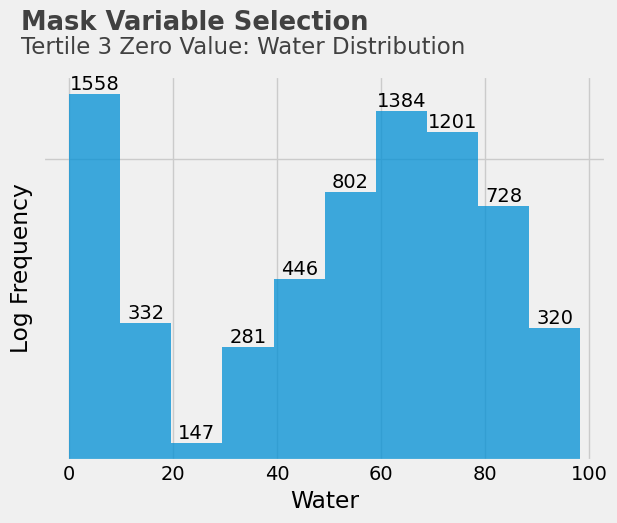

In [13]:
histogram(df = nutrition_df, col = 'water',output_prefix = f'{notebook_nm}-water-var-sel',fig_dir = fig_dir, title = 'Mask Variable Selection', subtitle = 'Tertile 3 Zero Value: Water Distribution', bins = 10, log_scale = True)

Image found in the "reports/figures" folder saved under 2.1-masking-sugars-var-sel_mask_variable_selection_tertile_2_zero_value:_sugars_distribution_sugars_hist.png


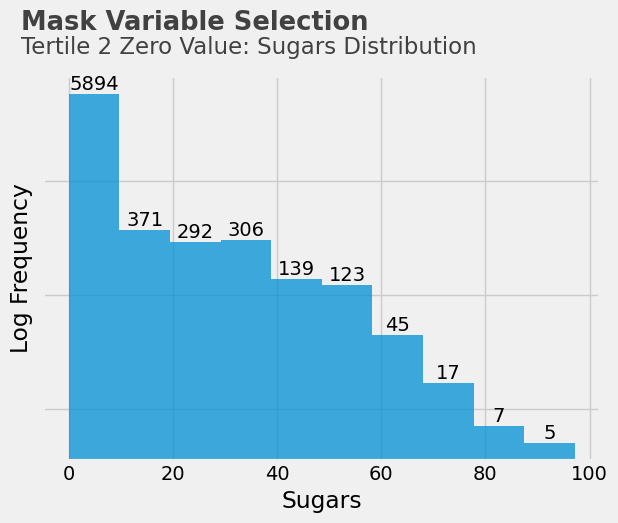

In [14]:
histogram(df = nutrition_df, col = 'sugars',output_prefix = f'{notebook_nm}-sugars-var-sel',fig_dir = fig_dir, title = 'Mask Variable Selection', subtitle = 'Tertile 2 Zero Value: Sugars Distribution', bins = 10, log_scale = True)

Image found in the "reports/figures" folder saved under 2.1-masking-vitamin_c-var-sel_mask_variable_selection_tertile_2_zero_value:_vitamin_c_distribution_vitamin_c_hist.png


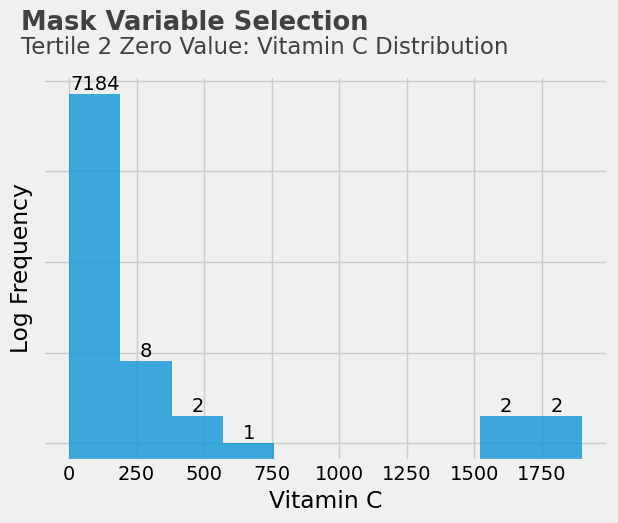

In [15]:
histogram(df = nutrition_df, col = 'vitamin_c',output_prefix = f'{notebook_nm}-vitamin_c-var-sel',fig_dir = fig_dir, title = 'Mask Variable Selection', subtitle = 'Tertile 2 Zero Value: Vitamin C Distribution', bins = 10, log_scale = True)

In [16]:
nutrient_impute_test_df[nutrient_impute_test_df.tertile_zero_value == 1].nlargest(50,'outlier_count')

Empty DataFrame
Columns: [nutrient, zero_value_counts, observation_count, z_score_zero_value_counts, percent_zero, outlier_count, variation_coefficient, missing_rate, median_value, tertile_zero_value, prop_na, mcar_test_mcar, mnar_test_mnar, mar_test_mar]
Index: []

In [17]:
nutrient_impute_test_df[nutrient_impute_test_df.tertile_zero_value == 2].nlargest(50,'outlier_count')

Empty DataFrame
Columns: [nutrient, zero_value_counts, observation_count, z_score_zero_value_counts, percent_zero, outlier_count, variation_coefficient, missing_rate, median_value, tertile_zero_value, prop_na, mcar_test_mcar, mnar_test_mnar, mar_test_mar]
Index: []

In [18]:
nutrient_impute_test_df[nutrient_impute_test_df.tertile_zero_value == 3].nlargest(50,'outlier_count')

Empty DataFrame
Columns: [nutrient, zero_value_counts, observation_count, z_score_zero_value_counts, percent_zero, outlier_count, variation_coefficient, missing_rate, median_value, tertile_zero_value, prop_na, mcar_test_mcar, mnar_test_mnar, mar_test_mar]
Index: []

In [19]:
nutrition_df['lutein_zeaxanthin'].describe()

count     7199.000000
mean        99.719822
std        847.378557
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      19697.000000
Name: lutein_zeaxanthin, dtype: float64

Image found in the "reports/figures" folder saved under 2.1-masking-magnesium-var-sel_mask_variable_selection_tertile_3_zero_value:_magnesium_distribution_magnesium_hist.png


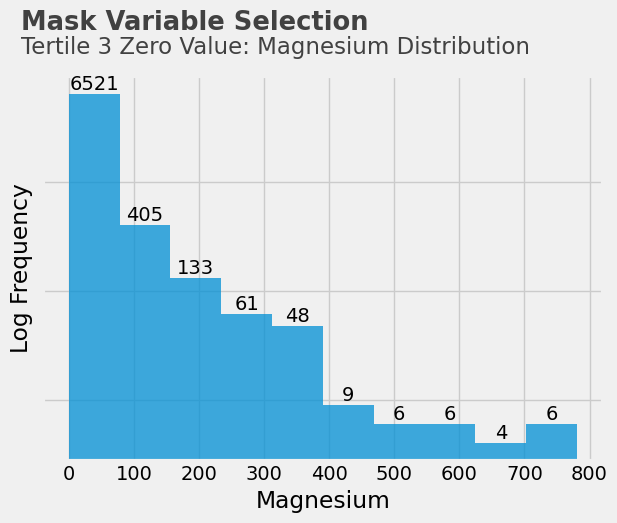

In [20]:
histogram(df = nutrition_df, col = 'magnesium',output_prefix = f'{notebook_nm}-magnesium-var-sel',fig_dir = fig_dir, title = 'Mask Variable Selection', subtitle = 'Tertile 3 Zero Value: Magnesium Distribution', bins = 10, log_scale = True)

Image found in the "reports/figures" folder saved under 2.1-masking-vitamin_d-var-sel_mask_variable_selection_tertile_1_zero_value:_vitamin_d_distribution_vitamin_d_hist.png


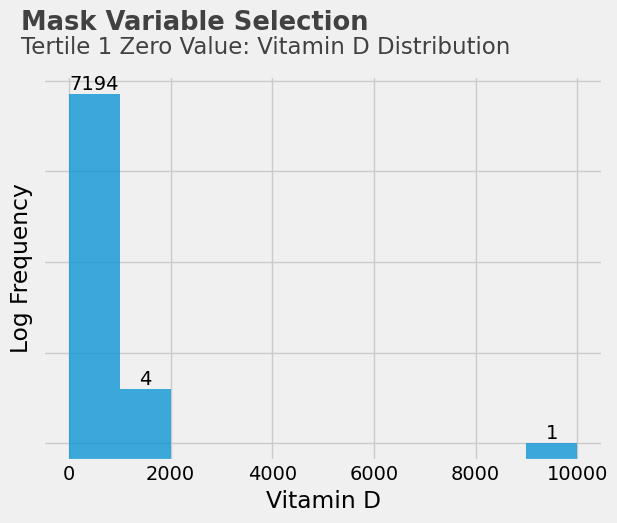

In [21]:
histogram(df = nutrition_df, col = 'vitamin_d',output_prefix = f'{notebook_nm}-vitamin_d-var-sel',fig_dir = fig_dir, title = 'Mask Variable Selection', subtitle = 'Tertile 1 Zero Value: Vitamin D Distribution', bins = 10, log_scale = True)

Image found in the "reports/figures" folder saved under 2.1-masking-lutein_zeaxanthin-var-sel_mask_variable_selection_tertile_1_zero_value:_lutein_zeaxanthin_distribution_lutein_zeaxanthin_hist.png


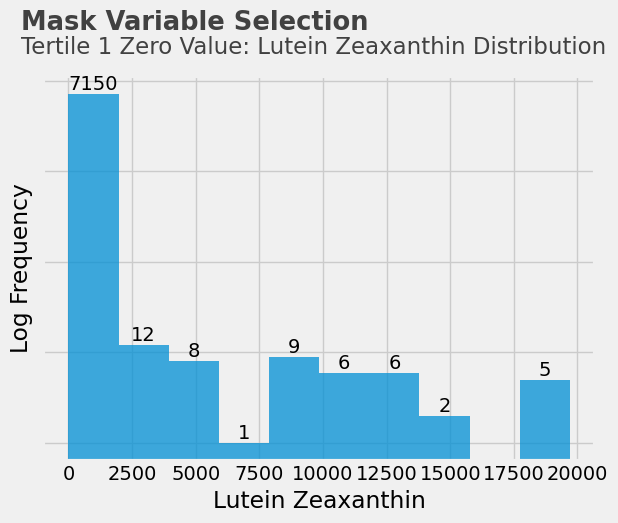

In [22]:
histogram(df = nutrition_df, col = 'lutein_zeaxanthin',output_prefix = f'{notebook_nm}-lutein_zeaxanthin-var-sel',fig_dir = fig_dir, title = 'Mask Variable Selection', subtitle = 'Tertile 1 Zero Value: Lutein Zeaxanthin Distribution', bins = 10, log_scale = True)

In [28]:
mt = MCARTest(method="little")

In [29]:
lutein_mcar_df = ampute(nutrition_df.set_index('name').drop(['serving_size'],axis='columns'), 'lutein_zeaxanthin', mechanism = 'MCAR', prop = 0.3, seed = 20)
ma = MultivariateAmputation(prop = 0.2, patterns = [{'incomplete_vars':['lutein_zeaxanthin'] ,'mechanism':'MAR', 'score_to_probability_func':'sigmoid-tail'}],verbose = True, seed = 20)
lutein_mar_df = ma.fit_transform(nutrition_df.set_index('name').drop(['serving_size'],axis='columns'))

mt.little_mcar_test(lutein_mar_df)

2022-11-27 15:37:12,593 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:37:12,749 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


0.0

In [30]:
water_mcar_df = ampute(nutrition_df.set_index('name').drop(['serving_size'],axis='columns'), 'water', mechanism = 'MCAR', prop = 0.2, seed = 20)
water_mar_df = ampute(nutrition_df.set_index('name').drop(['serving_size'],axis='columns'), 'water', mechanism = 'MAR', prop = 0.1, seed = 20)
mt.little_mcar_test(water_mar_df)

2022-11-27 15:37:13,613 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:37:13,813 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


0.0

In [31]:
sugars_mcar_df = ampute(nutrition_df.set_index('name').drop(['serving_size'],axis='columns'), 'sugars', mechanism = 'MCAR', prop = 0.3, seed = 20)
sugars_mar_df = ampute(nutrition_df.set_index('name').drop(['serving_size'],axis='columns'), 'sugars', mechanism = 'MAR', prop = 0.1, seed = 20)
mt.little_mcar_test(water_mar_df)

2022-11-27 15:37:14,638 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 15:37:14,830 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


0.0

In [32]:
mt.little_mcar_test(lutein_mar_df)

0.0

In [33]:
full_targets_df = nutrition_df.set_index('name')[['water','sugars','lutein_zeaxanthin']]
lutein_df = nutrition_df.set_index('name').drop('lutein_zeaxanthin', axis = 'columns').join(lutein_mcar_df[['lutein_zeaxanthin']].join(lutein_mar_df[['lutein_zeaxanthin']],lsuffix = '_mcar',rsuffix = '_mar').join(full_targets_df['lutein_zeaxanthin'],rsuffix = '_complete'))
lutein_df#.isnull().sum()#[['lutein_zeaxanthin_missing','lutein_zeaxanthin_complete']]

serving_size  total_fat  \
name                                                                          
Nuts, pecans                                                 100       72.0   
Teff, uncooked                                               100        2.4   
Sherbet, orange                                              100        2.0   
Cauliflower, raw                                             100        0.3   
Taro leaves, raw                                             100        0.7   
...                                                          ...        ...   
Beef, raw, all grades, trimmed to 0" fat, separ...           100        3.5   
Lamb, cooked, separable lean only, composite of...           100        8.9   
Lamb, raw, separable lean and fat, composite of...           100       23.0   
Beef, raw, all grades, trimmed to 0" fat, separ...           100        3.0   
Beef, raw, all grades, trimmed to 0" fat, separ...           100        3.0   

                                                    saturated_fat  \
name                                                                
Nuts, pecans                                                  6.2   
Teff, uncooked                                                0.4   
Sherbet, orange                                               1.2   
Cauliflower, raw                                              0.1   
Taro leaves, raw                                              0.2   
...                                                           ...   
Beef, raw, all grades, trimmed to 0" fat, separ...            1.4   
Lamb, cooked, separable lean only, composite of...            3.9   
Lamb, raw, separable lean and fat, composite of...           12.0   
Beef, raw, all grades, trimmed to 0" fat, separ...            1.1   
Beef, raw, all grades, trimmed to 0" fat, separ...            1.1   

                                                    cholesterol  sodium  \
name                                                                      
Nuts, pecans                                                  0     0.0   
Teff, uncooked                                                0    12.0   
Sherbet, orange                                               1    46.0   
Cauliflower, raw                                              0    30.0   
Taro leaves, raw                                              0     3.0   
...                                                         ...     ...   
Beef, raw, all grades, trimmed to 0" fat, separ...           62    54.0   
Lamb, cooked, separable lean only, composite of...          109    50.0   
Lamb, raw, separable lean and fat, composite of...           78    39.0   
Beef, raw, all grades, trimmed to 0" fat, separ...           60    53.0   
Beef, raw, all grades, trimmed to 0" fat, separ...           60    53.0   

                                                    choline  folate  \
name                                                                  
Nuts, pecans                                           40.5    22.0   
Teff, uncooked                                         13.1     0.0   
Sherbet, orange                                         7.7     4.0   
Cauliflower, raw                                       44.3    57.0   
Taro leaves, raw                                       12.8   126.0   
...                                                     ...     ...   
Beef, raw, all grades, trimmed to 0" fat, separ...     64.5     4.0   
Lamb, cooked, separable lean only, composite of...      0.0     0.0   
Lamb, raw, separable lean and fat, composite of...      0.0     1.0   
Beef, raw, all grades, trimmed to 0" fat, separ...     64.2     4.0   
Beef, raw, all grades, trimmed to 0" fat, separ...     64.2     4.0   

                                                    folic_acid  niacin  \
name                                                                     
Nuts, pecans                                               0.0   1.167   
Teff

In [34]:
sugars_df = nutrition_df.set_index('name').drop('sugars', axis = 'columns').join(sugars_mcar_df[['sugars']].join(sugars_mar_df[['sugars']],lsuffix = '_mcar',rsuffix = '_mar').join(full_targets_df['sugars'],rsuffix = '_complete'))
sugars_df.isnull().sum().nlargest(3)

sugars_mcar     2251
sugars_mar       704
serving_size       0
dtype: int64

In [35]:
water_df = nutrition_df.set_index('name').drop('water', axis = 'columns').join(water_mcar_df[['water']].join(water_mar_df[['water']],lsuffix = '_mcar',rsuffix = '_mar').join(full_targets_df['water'],rsuffix = '_complete'))
water_df.isnull().sum().nlargest(3)

water_mcar      1476
water_mar        706
serving_size       0
dtype: int64

In [36]:
water_df.to_csv(f'{ROOT_DIR}/data/processed/water.csv', index=True)
sugars_df.to_csv(f'{ROOT_DIR}/data/processed/sugars.csv', index=True)
lutein_df.to_csv(f'{ROOT_DIR}/data/processed/lutein.csv', index=True)

In [64]:
water_df

serving_size  total_fat  \
name                                                                          
Nuts, pecans                                                 100       72.0   
Teff, uncooked                                               100        2.4   
Sherbet, orange                                              100        2.0   
Cauliflower, raw                                             100        0.3   
Taro leaves, raw                                             100        0.7   
...                                                          ...        ...   
Beef, raw, all grades, trimmed to 0" fat, separ...           100        3.5   
Lamb, cooked, separable lean only, composite of...           100        8.9   
Lamb, raw, separable lean and fat, composite of...           100       23.0   
Beef, raw, all grades, trimmed to 0" fat, separ...           100        3.0   
Beef, raw, all grades, trimmed to 0" fat, separ...           100        3.0   

                                                    saturated_fat  \
name                                                                
Nuts, pecans                                                  6.2   
Teff, uncooked                                                0.4   
Sherbet, orange                                               1.2   
Cauliflower, raw                                              0.1   
Taro leaves, raw                                              0.2   
...                                                           ...   
Beef, raw, all grades, trimmed to 0" fat, separ...            1.4   
Lamb, cooked, separable lean only, composite of...            3.9   
Lamb, raw, separable lean and fat, composite of...           12.0   
Beef, raw, all grades, trimmed to 0" fat, separ...            1.1   
Beef, raw, all grades, trimmed to 0" fat, separ...            1.1   

                                                    cholesterol  sodium  \
name                                                                      
Nuts, pecans                                                  0     0.0   
Teff, uncooked                                                0    12.0   
Sherbet, orange                                               1    46.0   
Cauliflower, raw                                              0    30.0   
Taro leaves, raw                                              0     3.0   
...                                                         ...     ...   
Beef, raw, all grades, trimmed to 0" fat, separ...           62    54.0   
Lamb, cooked, separable lean only, composite of...          109    50.0   
Lamb, raw, separable lean and fat, composite of...           78    39.0   
Beef, raw, all grades, trimmed to 0" fat, separ...           60    53.0   
Beef, raw, all grades, trimmed to 0" fat, separ...           60    53.0   

                                                    choline  folate  \
name                                                                  
Nuts, pecans                                           40.5    22.0   
Teff, uncooked                                         13.1     0.0   
Sherbet, orange                                         7.7     4.0   
Cauliflower, raw                                       44.3    57.0   
Taro leaves, raw                                       12.8   126.0   
...                                                     ...     ...   
Beef, raw, all grades, trimmed to 0" fat, separ...     64.5     4.0   
Lamb, cooked, separable lean only, composite of...      0.0     0.0   
Lamb, raw, separable lean and fat, composite of...      0.0     1.0   
Beef, raw, all grades, trimmed to 0" fat, separ...     64.2     4.0   
Beef, raw, all grades, trimmed to 0" fat, separ...     64.2     4.0   

                                                    folic_acid  niacin  \
name                                                                     
Nuts, pecans                                               0.0   1.167   
Teff

In [82]:
water_mar_df = water_df
water_mar_df['dataset_type'] = np.where(water_mar_df['water_mar'].isnull(),'validation','training')
water_mar_df = water_mar_df.reset_index().set_index(['dataset_type','name'])#.set_index(['dataset_type','name'],inplace = True)
water_mar_df.reset_index().head(50)

dataset_type                    name  serving_size  total_fat  \
0      training            Nuts, pecans           100       72.0   
1      training          Teff, uncooked           100        2.4   
2      training         Sherbet, orange           100        2.0   
3      training        Cauliflower, raw           100        0.3   
4      training        Taro leaves, raw           100        0.7   
5      training       Lamb, raw, ground           100       23.0   
6      training       Cheese, camembert           100       24.0   
7      training      Vegetarian fillets           100       18.0   
8      training    Crackers, rusk toast           100        7.2   
9      training   Chicken, boiled, feet           100       15.0   
10     training   Quail, raw, meat only           100        4.5   
11     training  Pie, lemon, fried pies           100       16.0   
12     training  Peppers, raw, jalapeno           100        0.4   
13     training  Winged bean tuber, raw           100        0.9   
14     training  Salami, turkey, cooked           100        9.2   
15     training  Nuts, raw, ginkgo nuts           100        1.7   
16     training  Spices, ground, savory           100        5.9   
17     training  Candies, sesame crunch           100       33.0   
18     training  Cheese, low fat, cream           100       15.0   
19     training  Ostrich, raw, top loin           100        3.0   
20     training  Chewing gum, sugarless           100        0.4   
21   validation  Nuts, dried, pine nuts           100       68.0   
22     training  Pasta, unenriched, dry           100        1.5   
23     training  Cookies, Marie biscuit           100       11.0   
24     training  Broccoli, raw, chinese           100        0.8   
25     training  McDONALD'S, Hash Brown           100       16.0   
26     training  Emu, raw, outside drum           100        0.5   
27     training  Nuts, dried, beechnuts           100       50.0   
28     training  Lentils, raw, sprouted           100        0.6   
29     training  Gravy, mix, dry, onion           100        3.0   
30     training  Pie, fruit, fried pies           100       16.0   
31     training  Snacks, cakes, popcorn           100        3.1   
32     training  Snack, Mixed Berry Bar           100       11.0   
33     training   Fish, raw, sheepshead           100        2.4   
34     training   Brussels sprouts, raw           100        0.3   
35     training   Broccoli raab, cooked           100        0.5   
36     training   Butter oil, anhydrous           100       99.0   
37     training   KEEBLER, Waffle Cones           100        5.3   
38     training   KEEBLER, Waffle Bowls           100        5.3   
39     training   Broccoli, raw, leaves           100        0.4   
40     training   Egg custards, dry mix           100        6.4   
41     training   Peanut flour, low fat           100       22.0   
42     training   Fish, smoked, haddock           100        1.0   
43     training   DENNY'S, french fries           100       14.0   
44     training   Ground turkey, cooked           100       10.0   
45     training   MURRAY, Vanilla Wafer           100       17.0   
46     training   WENDY'S, french fries           100       14.0   
47     training   Bread, toasted, wheat           100        4.3   
48     training   Danish pastry, cheese           100       22.0   
49     training   Nuts, glazed, walnuts           100       36.0   

    saturated_fat  cholesterol  sodium  choline  folate  folic_acid  niacin  \
0             6.2            0     0.0     40.5    22.0         0.0   1.167   
1             0.4            0    12.0     13.1     0.0         0.0   3.363   
2             1.2            1    46.0      7.7     4.0         0.0   0.063   
3             0.1            0    30.0     44.3    57.0         0.0   0.507   
4             0.2            0     3.0     12.8   126.0         0.0   1.513   
5            10.0           73    59.0     69.3    18.0     

In [86]:
scaler_water_mar = StandardScaler()
water_mar_df = water_df
water_mar_df['dataset_type'] = np.where(water_mar_df['water_mar'].isnull(),'validation','training')
water_mar_df = water_mar_df.reset_index().set_index(['dataset_type','name']).drop(['water_mcar','water'],axis = 'columns')#.dropna(axis = 'rows')
# water_mar_df['water_mar'] = water_mar_df['water_mar'].fillna(0)
water_mar_train_scaled_df = scaler_water_mar.fit_transform(water_mar_df)
water_mar_train_scaled_df = water_mar_df.reset_index()[['name','dataset_type']].join(pd.DataFrame(water_mar_train_scaled_df,columns = water_mar_df.columns))
water_mar_train_scaled_df#.head(50)

name dataset_type  serving_size  total_fat  \
0             Nuts, pecans     training           0.0   3.596307   
1           Teff, uncooked     training           0.0  -0.619342   
2          Sherbet, orange     training           0.0  -0.643570   
3         Cauliflower, raw     training           0.0  -0.746538   
4         Taro leaves, raw     training           0.0  -0.722310   
5        Lamb, raw, ground     training           0.0   0.628393   
6        Cheese, camembert     training           0.0   0.688963   
7       Vegetarian fillets     training           0.0   0.325545   
8     Crackers, rusk toast     training           0.0  -0.328607   
9    Chicken, boiled, feet     training           0.0   0.143836   
10   Quail, raw, meat only     training           0.0  -0.492146   
11  Pie, lemon, fried pies     training           0.0   0.204406   
12  Peppers, raw, jalapeno     training           0.0  -0.740481   
13  Winged bean tuber, raw     training           0.0  -0.710196   
14  Salami, turkey, cooked     training           0.0  -0.207468   
15  Nuts, raw, ginkgo nuts     training           0.0  -0.661741   
16  Spices, ground, savory     training           0.0  -0.407348   
17  Candies, sesame crunch     training           0.0   1.234090   
18  Cheese, low fat, cream     training           0.0   0.143836   
19  Ostrich, raw, top loin     training           0.0  -0.583000   
20  Chewing gum, sugarless     training           0.0  -0.740481   
21  Nuts, dried, pine nuts   validation           0.0   3.354028   
22  Pasta, unenriched, dry     training           0.0  -0.673855   
23  Cookies, Marie biscuit     training           0.0  -0.098443   
24  Broccoli, raw, chinese     training           0.0  -0.716253   
25  McDONALD'S, Hash Brown     training           0.0   0.204406   
26  Emu, raw, outside drum     training           0.0  -0.734424   
27  Nuts, dried, beechnuts     training           0.0   2.263774   
28  Lentils, raw, sprouted     training           0.0  -0.728367   
29  Gravy, mix, dry, onion     training           0.0  -0.583000   
30  Pie, fruit, fried pies     training           0.0   0.204406   
31  Snacks, cakes, popcorn     training           0.0  -0.576943   
32  Snack, Mixed Berry Bar     training           0.0  -0.098443   
33   Fish, raw, sheepshead     training           0.0  -0.619342   
34   Brussels sprouts, raw     training           0.0  -0.746538   
35   Broccoli raab, cooked     training           0.0  -0.734424   
36   Butter oil, anhydrous     training           0.0   5.231688   
37   KEEBLER, Waffle Cones     training           0.0  -0.443690   
38   KEEBLER, Waffle Bowls     training           0.0  -0.443690   
39   Broccoli, raw, leaves     training           0.0  -0.740481   
40   Egg custards, dry mix     training           0.0  -0.377063   
41   Peanut flour, low fat     training           0.0   0.567824   
42   Fish, smoked, haddock     training           0.0  -0.704139   
43   DENNY'S, french fries     training           0.0   0.083266   
44   Ground turkey, cooked     training           0.0  -0.159012   
45   MURRAY, Vanilla Wafer     training           0.0   0.264975   
46   WENDY'S, french fries     training           0.0   0.083266   
47   Bread, toasted, wheat     training           0.0  -0.504260   
48   Danish pastry, cheese     training           0.0   0.567824   
49   Nuts, glazed, walnuts     training           0.0   1.415799   

    saturated_fat  cholesterol    sodium   choline    folate  folic_acid  \
0        0.291893    -0.366113 -0.435551  0.228384 -0.209526   -0.198124   
1       -0.551556    -0.366113 -0.419401 -0.264566 -0.377104   -0.198124   
2       -0.435218    -0.358304 -0.373641 -0.361717 -0.346635   -0.198124   
3       -0.595182    -0.366113 -0.395175  0.296750  0.057075   -0.198124   
4       -0.580640    -0.366113 -0.431514 -0.269964  0.582661   -0.198124   
5        0.844497     0.203946 -0.356145  0.746522 -0.239995   -0.198124   
6        1.571608    

In [93]:
scaler_water_mcar = StandardScaler()
water_mcar_df = water_df
water_mcar_df['dataset_type'] = np.where(water_mcar_df['water_mcar'].isnull(),'validation','training')
water_mcar_df = water_mcar_df.reset_index().set_index(['dataset_type','name']).drop(['water_mar','water'],axis = 'columns')#.dropna(axis = 'rows')
# water_mar_df['water_mar'] = water_mar_df['water_mar'].fillna(0)
water_mcar_train_scaled_df = scaler_water_mcar.fit_transform(water_mcar_df)
water_mcar_train_scaled_df = water_mcar_df.reset_index()[['name','dataset_type']].join(pd.DataFrame(water_mcar_train_scaled_df,columns = water_mcar_df.columns))
water_mcar_train_scaled_df.head(50)

name dataset_type  serving_size  total_fat  \
0             Nuts, pecans     training           0.0   3.596307   
1           Teff, uncooked   validation           0.0  -0.619342   
2          Sherbet, orange   validation           0.0  -0.643570   
3         Cauliflower, raw   validation           0.0  -0.746538   
4         Taro leaves, raw     training           0.0  -0.722310   
5        Lamb, raw, ground     training           0.0   0.628393   
6        Cheese, camembert     training           0.0   0.688963   
7       Vegetarian fillets     training           0.0   0.325545   
8     Crackers, rusk toast     training           0.0  -0.328607   
9    Chicken, boiled, feet     training           0.0   0.143836   
10   Quail, raw, meat only     training           0.0  -0.492146   
11  Pie, lemon, fried pies     training           0.0   0.204406   
12  Peppers, raw, jalapeno     training           0.0  -0.740481   
13  Winged bean tuber, raw   validation           0.0  -0.710196   
14  Salami, turkey, cooked     training           0.0  -0.207468   
15  Nuts, raw, ginkgo nuts     training           0.0  -0.661741   
16  Spices, ground, savory     training           0.0  -0.407348   
17  Candies, sesame crunch     training           0.0   1.234090   
18  Cheese, low fat, cream     training           0.0   0.143836   
19  Ostrich, raw, top loin     training           0.0  -0.583000   
20  Chewing gum, sugarless   validation           0.0  -0.740481   
21  Nuts, dried, pine nuts   validation           0.0   3.354028   
22  Pasta, unenriched, dry     training           0.0  -0.673855   
23  Cookies, Marie biscuit     training           0.0  -0.098443   
24  Broccoli, raw, chinese     training           0.0  -0.716253   
25  McDONALD'S, Hash Brown     training           0.0   0.204406   
26  Emu, raw, outside drum     training           0.0  -0.734424   
27  Nuts, dried, beechnuts   validation           0.0   2.263774   
28  Lentils, raw, sprouted     training           0.0  -0.728367   
29  Gravy, mix, dry, onion     training           0.0  -0.583000   
30  Pie, fruit, fried pies     training           0.0   0.204406   
31  Snacks, cakes, popcorn     training           0.0  -0.576943   
32  Snack, Mixed Berry Bar     training           0.0  -0.098443   
33   Fish, raw, sheepshead     training           0.0  -0.619342   
34   Brussels sprouts, raw     training           0.0  -0.746538   
35   Broccoli raab, cooked     training           0.0  -0.734424   
36   Butter oil, anhydrous     training           0.0   5.231688   
37   KEEBLER, Waffle Cones     training           0.0  -0.443690   
38   KEEBLER, Waffle Bowls     training           0.0  -0.443690   
39   Broccoli, raw, leaves     training           0.0  -0.740481   
40   Egg custards, dry mix     training           0.0  -0.377063   
41   Peanut flour, low fat     training           0.0   0.567824   
42   Fish, smoked, haddock     training           0.0  -0.704139   
43   DENNY'S, french fries     training           0.0   0.083266   
44   Ground turkey, cooked     training           0.0  -0.159012   
45   MURRAY, Vanilla Wafer     training           0.0   0.264975   
46   WENDY'S, french fries     training           0.0   0.083266   
47   Bread, toasted, wheat     training           0.0  -0.504260   
48   Danish pastry, cheese   validation           0.0   0.567824   
49   Nuts, glazed, walnuts     training           0.0   1.415799   

    saturated_fat  cholesterol    sodium   choline    folate  folic_acid  \
0        0.291893    -0.366113 -0.435551  0.228384 -0.209526   -0.198124   
1       -0.551556    -0.366113 -0.419401 -0.264566 -0.377104   -0.198124   
2       -0.435218    -0.358304 -0.373641 -0.361717 -0.346635   -0.198124   
3       -0.595182    -0.366113 -0.395175  0.296750  0.057075   -0.198124   
4       -0.580640    -0.366113 -0.431514 -0.269964  0.582661   -0.198124   
5        0.844497     0.203946 -0.356145  0.746522 -0.239995   -0.198124   
6        1.571608    

In [94]:
scaler_sugars_mcar = StandardScaler()
sugars_mcar_df = sugars_df
sugars_mcar_df['dataset_type'] = np.where(sugars_mcar_df['sugars_mcar'].isnull(),'validation','training')
sugars_mcar_df = sugars_mcar_df.reset_index().set_index(['dataset_type','name']).drop(['sugars_mar','sugars'],axis = 'columns')#.dropna(axis = 'rows')
# water_mar_df['water_mar'] = water_mar_df['water_mar'].fillna(0)
sugars_mcar_train_scaled_df = scaler_sugars_mcar.fit_transform(sugars_mcar_df)
sugars_mcar_train_scaled_df = sugars_mcar_df.reset_index()[['name','dataset_type']].join(pd.DataFrame(sugars_mcar_train_scaled_df,columns = sugars_mcar_df.columns))
sugars_mcar_train_scaled_df.head(50)

name dataset_type  serving_size  total_fat  \
0             Nuts, pecans     training           0.0   3.596307   
1           Teff, uncooked   validation           0.0  -0.619342   
2          Sherbet, orange   validation           0.0  -0.643570   
3         Cauliflower, raw   validation           0.0  -0.746538   
4         Taro leaves, raw     training           0.0  -0.722310   
5        Lamb, raw, ground     training           0.0   0.628393   
6        Cheese, camembert     training           0.0   0.688963   
7       Vegetarian fillets     training           0.0   0.325545   
8     Crackers, rusk toast     training           0.0  -0.328607   
9    Chicken, boiled, feet     training           0.0   0.143836   
10   Quail, raw, meat only     training           0.0  -0.492146   
11  Pie, lemon, fried pies   validation           0.0   0.204406   
12  Peppers, raw, jalapeno   validation           0.0  -0.740481   
13  Winged bean tuber, raw   validation           0.0  -0.710196   
14  Salami, turkey, cooked   validation           0.0  -0.207468   
15  Nuts, raw, ginkgo nuts     training           0.0  -0.661741   
16  Spices, ground, savory     training           0.0  -0.407348   
17  Candies, sesame crunch   validation           0.0   1.234090   
18  Cheese, low fat, cream     training           0.0   0.143836   
19  Ostrich, raw, top loin     training           0.0  -0.583000   
20  Chewing gum, sugarless   validation           0.0  -0.740481   
21  Nuts, dried, pine nuts   validation           0.0   3.354028   
22  Pasta, unenriched, dry     training           0.0  -0.673855   
23  Cookies, Marie biscuit     training           0.0  -0.098443   
24  Broccoli, raw, chinese   validation           0.0  -0.716253   
25  McDONALD'S, Hash Brown     training           0.0   0.204406   
26  Emu, raw, outside drum     training           0.0  -0.734424   
27  Nuts, dried, beechnuts   validation           0.0   2.263774   
28  Lentils, raw, sprouted     training           0.0  -0.728367   
29  Gravy, mix, dry, onion     training           0.0  -0.583000   
30  Pie, fruit, fried pies     training           0.0   0.204406   
31  Snacks, cakes, popcorn     training           0.0  -0.576943   
32  Snack, Mixed Berry Bar     training           0.0  -0.098443   
33   Fish, raw, sheepshead     training           0.0  -0.619342   
34   Brussels sprouts, raw   validation           0.0  -0.746538   
35   Broccoli raab, cooked     training           0.0  -0.734424   
36   Butter oil, anhydrous     training           0.0   5.231688   
37   KEEBLER, Waffle Cones     training           0.0  -0.443690   
38   KEEBLER, Waffle Bowls     training           0.0  -0.443690   
39   Broccoli, raw, leaves     training           0.0  -0.740481   
40   Egg custards, dry mix     training           0.0  -0.377063   
41   Peanut flour, low fat     training           0.0   0.567824   
42   Fish, smoked, haddock     training           0.0  -0.704139   
43   DENNY'S, french fries     training           0.0   0.083266   
44   Ground turkey, cooked     training           0.0  -0.159012   
45   MURRAY, Vanilla Wafer     training           0.0   0.264975   
46   WENDY'S, french fries     training           0.0   0.083266   
47   Bread, toasted, wheat     training           0.0  -0.504260   
48   Danish pastry, cheese   validation           0.0   0.567824   
49   Nuts, glazed, walnuts     training           0.0   1.415799   

    saturated_fat  cholesterol    sodium   choline    folate  folic_acid  \
0        0.291893    -0.366113 -0.435551  0.228384 -0.209526   -0.198124   
1       -0.551556    -0.366113 -0.419401 -0.264566 -0.377104   -0.198124   
2       -0.435218    -0.358304 -0.373641 -0.361717 -0.346635   -0.198124   
3       -0.595182    -0.366113 -0.395175  0.296750  0.057075   -0.198124   
4       -0.580640    -0.366113 -0.431514 -0.269964  0.582661   -0.198124   
5        0.844497     0.203946 -0.356145  0.746522 -0.239995   -0.198124   
6        1.571608    

In [101]:
scaler_sugars_mar = StandardScaler()
sugars_mar_df = sugars_df
sugars_mar_df['dataset_type'] = np.where(sugars_mar_df['sugars_mar'].isnull(),'validation','training')
sugars_mar_df = sugars_mar_df.reset_index().set_index(['dataset_type','name']).drop(['sugars_mcar','sugars'],axis = 'columns')#.dropna(axis = 'rows')
# water_mar_df['water_mar'] = water_mar_df['water_mar'].fillna(0)
sugars_mar_train_scaled_df = scaler_sugars_mar.fit_transform(sugars_mar_df)
sugars_mar_train_scaled_df = sugars_mar_df.reset_index()[['name','dataset_type']].join(pd.DataFrame(sugars_mar_train_scaled_df,columns = sugars_mar_df.columns))
sugars_mar_train_scaled_df

name dataset_type  \
0                                          Nuts, pecans     training   
1                                        Teff, uncooked     training   
2                                       Sherbet, orange     training   
3                                      Cauliflower, raw     training   
4                                      Taro leaves, raw     training   
...                                                 ...          ...   
7194  Beef, raw, all grades, trimmed to 0" fat, sepa...     training   
7195  Lamb, cooked, separable lean only, composite o...     training   
7196  Lamb, raw, separable lean and fat, composite o...     training   
7197  Beef, raw, all grades, trimmed to 0" fat, sepa...     training   
7198  Beef, raw, all grades, trimmed to 0" fat, sepa...     training   

      serving_size  total_fat  saturated_fat  cholesterol    sodium   choline  \
0              0.0   3.596307       0.291893    -0.366113 -0.435551  0.228384   
1              0.0  -0.619342      -0.551556    -0.366113 -0.419401 -0.264566   
2              0.0  -0.643570      -0.435218    -0.358304 -0.373641 -0.361717   
3              0.0  -0.746538      -0.595182    -0.366113 -0.395175  0.296750   
4              0.0  -0.722310      -0.580640    -0.366113 -0.431514 -0.269964   
...            ...        ...            ...          ...       ...       ...   
7194           0.0  -0.552715      -0.406134     0.118047 -0.362874  0.660166   
7195           0.0  -0.225639      -0.042578     0.485071 -0.368257 -0.500247   
7196           0.0   0.628393       1.135341     0.242991 -0.383062 -0.500247   
7197           0.0  -0.583000      -0.449760     0.102428 -0.364220  0.654769   
7198           0.0  -0.583000      -0.449760     0.102428 -0.364220  0.654769   

        folate  folic_acid    niacin  pantothenic_acid  riboflavin   thiamin  \
0    -0.209526   -0.198124 -0.598476          0.235663   -0.329650  0.875784   
1    -0.377104   -0.198124 -0.121463          0.295053    0.016684  0.315431   
2    -0.346635   -0.198124 -0.838286         -0.244720   -0.411286 -0.437932   
3     0.057075   -0.198124 -0.741841          0.088316   -0.502818 -0.390198   
4     0.582661   -0.198124 -0.523319         -0.349968    0.476815 -0.060213   
...        ...         ...       ...               ...         ...       ...   
7194 -0.346635   -0.198124  0.543009         -0.145486   -0.072373 -0.363218   
7195 -0.377104   -0.198124  0.816271          0.022911    0.585663 -0.224168   
7196 -0.369487   -0.198124  0.570813         -0.022195    0.140375 -0.224168   
7197 -0.346635   -0.198124  0.607741         -0.146238   -0.196064 -0.363218   
7198 -0.346635   -0.198124  0.607741         -0.146238   -0.196064 -0.363218   

      vitamin_a  vitamin_a_rae  carotene_alpha  carotene_beta  \
0     -0.151787      -0.116302        -0.06443      -0.077065   
1     -0.165265      -0.119859        -0.06443      -0.101149   
2     -0.154655      -0.105630        -0.06443      -0.105163   
3     -0.167846      -0.119859        -0.06443      -0.106167   
4      1.215804       0.165906        -0.06443       2.799010   
...         ...            ...             ...            ...   
7194  -0.164692      -0.116302        -0.06443      -0.106167   
7195  -0.167846      -0.119859        -0.06443      -0.106167   
7196  -0.167846      -0.119859        -0.06443      -0.106167   
7197  -0.166699      -0.118673        -0.06443      -0.106167   
7198  -0.166126      -0.117488        -0.06443      -0.106167   

      cryptoxanthin_beta  lutein_zeaxanthin  vitamin_b12  vitamin_b6  \
0               0.039505          -0.097625    -0.312098   -0.176382   
1              -0.039304          -0.039796    -0.312098    0.387865   
2               0.004479          -0.109427    -0.283870   -0.564302   
3              -0.039304          -0.116508    -0.312098   -0.230317   
4              -0.039304           2.162443    -0.312098   -0.309146   
...                  ...               

In [104]:
scaler_lutein_mcar = StandardScaler()
lutein_mcar_df = lutein_df
lutein_mcar_df['dataset_type'] = np.where(lutein_mcar_df['lutein_zeaxanthin_mcar'].isnull(),'validation','training')
lutein_mcar_df = lutein_mcar_df.reset_index().set_index(['dataset_type','name']).drop(['lutein_zeaxanthin_mar','lutein_zeaxanthin'],axis = 'columns')#.dropna(axis = 'rows')
# water_mar_df['water_mar'] = water_mar_df['water_mar'].fillna(0)
lutein_mcar_train_scaled_df = scaler_lutein_mcar.fit_transform(lutein_mcar_df)
lutein_mcar_train_scaled_df = lutein_mcar_df.reset_index()[['name','dataset_type']].join(pd.DataFrame(lutein_mcar_train_scaled_df,columns = lutein_mcar_df.columns))
lutein_mcar_train_scaled_df.head(50)

name dataset_type  serving_size  total_fat  \
0             Nuts, pecans     training           0.0   3.596307   
1           Teff, uncooked   validation           0.0  -0.619342   
2          Sherbet, orange   validation           0.0  -0.643570   
3         Cauliflower, raw   validation           0.0  -0.746538   
4         Taro leaves, raw     training           0.0  -0.722310   
5        Lamb, raw, ground     training           0.0   0.628393   
6        Cheese, camembert     training           0.0   0.688963   
7       Vegetarian fillets     training           0.0   0.325545   
8     Crackers, rusk toast     training           0.0  -0.328607   
9    Chicken, boiled, feet     training           0.0   0.143836   
10   Quail, raw, meat only     training           0.0  -0.492146   
11  Pie, lemon, fried pies   validation           0.0   0.204406   
12  Peppers, raw, jalapeno   validation           0.0  -0.740481   
13  Winged bean tuber, raw   validation           0.0  -0.710196   
14  Salami, turkey, cooked   validation           0.0  -0.207468   
15  Nuts, raw, ginkgo nuts     training           0.0  -0.661741   
16  Spices, ground, savory     training           0.0  -0.407348   
17  Candies, sesame crunch   validation           0.0   1.234090   
18  Cheese, low fat, cream     training           0.0   0.143836   
19  Ostrich, raw, top loin     training           0.0  -0.583000   
20  Chewing gum, sugarless   validation           0.0  -0.740481   
21  Nuts, dried, pine nuts   validation           0.0   3.354028   
22  Pasta, unenriched, dry     training           0.0  -0.673855   
23  Cookies, Marie biscuit     training           0.0  -0.098443   
24  Broccoli, raw, chinese   validation           0.0  -0.716253   
25  McDONALD'S, Hash Brown     training           0.0   0.204406   
26  Emu, raw, outside drum     training           0.0  -0.734424   
27  Nuts, dried, beechnuts   validation           0.0   2.263774   
28  Lentils, raw, sprouted     training           0.0  -0.728367   
29  Gravy, mix, dry, onion     training           0.0  -0.583000   
30  Pie, fruit, fried pies     training           0.0   0.204406   
31  Snacks, cakes, popcorn     training           0.0  -0.576943   
32  Snack, Mixed Berry Bar     training           0.0  -0.098443   
33   Fish, raw, sheepshead     training           0.0  -0.619342   
34   Brussels sprouts, raw   validation           0.0  -0.746538   
35   Broccoli raab, cooked     training           0.0  -0.734424   
36   Butter oil, anhydrous     training           0.0   5.231688   
37   KEEBLER, Waffle Cones     training           0.0  -0.443690   
38   KEEBLER, Waffle Bowls     training           0.0  -0.443690   
39   Broccoli, raw, leaves     training           0.0  -0.740481   
40   Egg custards, dry mix     training           0.0  -0.377063   
41   Peanut flour, low fat     training           0.0   0.567824   
42   Fish, smoked, haddock     training           0.0  -0.704139   
43   DENNY'S, french fries     training           0.0   0.083266   
44   Ground turkey, cooked     training           0.0  -0.159012   
45   MURRAY, Vanilla Wafer     training           0.0   0.264975   
46   WENDY'S, french fries     training           0.0   0.083266   
47   Bread, toasted, wheat     training           0.0  -0.504260   
48   Danish pastry, cheese   validation           0.0   0.567824   
49   Nuts, glazed, walnuts     training           0.0   1.415799   

    saturated_fat  cholesterol    sodium   choline    folate  folic_acid  \
0        0.291893    -0.366113 -0.435551  0.228384 -0.209526   -0.198124   
1       -0.551556    -0.366113 -0.419401 -0.264566 -0.377104   -0.198124   
2       -0.435218    -0.358304 -0.373641 -0.361717 -0.346635   -0.198124   
3       -0.595182    -0.366113 -0.395175  0.296750  0.057075   -0.198124   
4       -0.580640    -0.366113 -0.431514 -0.269964  0.582661   -0.198124   
5        0.844497     0.203946 -0.356145  0.746522 -0.239995   -0.198124   
6        1.571608    

In [ ]:
scaler_lutein_mcar = StandardScaler()
lutein_mcar_df = lutein_df
lutein_mcar_df['dataset_type'] = np.where(lutein_mcar_df['lutein_zeaxanthin_mcar'].isnull(),'validation','training')
lutein_mcar_df = lutein_mcar_df.reset_index().set_index(['dataset_type','name']).drop(['lutein_zeaxanthin_mar','lutein_zeaxanthin'],axis = 'columns')#.dropna(axis = 'rows')
# water_mar_df['water_mar'] = water_mar_df['water_mar'].fillna(0)
lutein_mcar_train_scaled_df = scaler_lutein_mcar.fit_transform(lutein_mcar_df)
lutein_mcar_train_scaled_df = lutein_mcar_df.reset_index()[['name','dataset_type']].join(pd.DataFrame(lutein_mcar_train_scaled_df,columns = lutein_mcar_df.columns))
lutein_mcar_train_scaled_df.head(50)

In [ ]:
nutrient_impute_test_df.to_csv(f'{ROOT_DIR}/data/interim/nutrition_statistics_impute_test_grid_search.csv', index=False)